# Detrend and clean dataset

This notebook is used to detrend and clean dataset using the maintenance dates

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

### Read input file of stations

In [2]:
ds = xr.open_dataset("../data/daily_UNR.nc").sel(time=slice("2010-01-01", "2024-01-01"))
ds = ds.dropna(dim="station", how="all", subset=['e'])
ds

<xarray.Dataset>
Dimensions:    (time: 5114, station: 1101)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2024-01-01
  * station    (station) object '34A1' '34A2' '34A3' ... 'YONC' 'ZOLE' 'ZSE1'
Data variables:
    e          (time, station) float64 nan nan nan nan ... -0.05722 nan 0.474
    n          (time, station) float64 ...
    z          (time, station) float64 ...
    latitude   (station) float64 ...
    longitude  (station) float64 ...
    height     (station) float64 ...

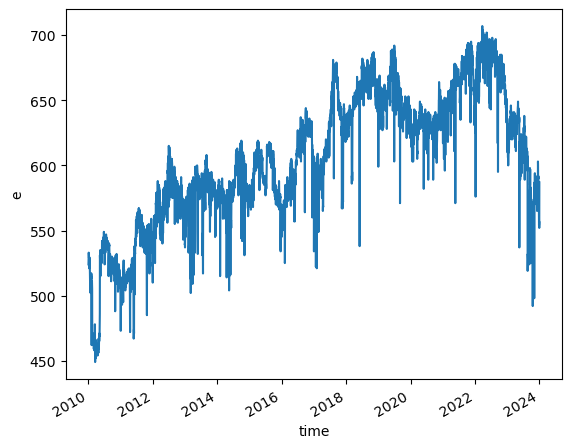

In [3]:
non_nan_counts = ds['e'].notnull().sum(dim='station')
non_nan_counts.plot()

### Read maintenance log file in pandas

The maintenance log file is publicly available here: http://geodesy.unr.edu/NGLStationPages/steps.txt 

In [5]:
def date_parser(date_str):
    return pd.to_datetime(date_str, format='%y%b%d')

df = pd.read_csv("./ressources/maintenance_stations.txt", delim_whitespace=True, header=None, nrows=15564, parse_dates=['date'],
            date_parser=date_parser, names = ['station', 'date', 'number', 'operation'])
df

,station,date,number,operation
0,00NA,2017-05-04,1,Antenna_Code_Changed
1,00NA,2017-05-04,1,Receiver_Make_and_Model_Changed
2,01NA,2017-05-04,1,Antenna_Code_Changed
3,01NA,2017-05-04,1,Receiver_Make_and_Model_Changed
4,0KUN,2005-05-11,1,Antenna_Code_Changed
...,...,...,...,...
15559,TONY,2006-01-06,1,Receiver_Make_and_Model_Changed
15560,TONY,2008-08-12,1,Antenna_and_Radome_Codes_Changed
15561,TRE5,2012-10-31,1,Equipment_Site_Change
15562,WIRP,2017-09-11,1,Equipment_Site_Change


In [6]:
df.set_index("date", inplace=True)

# detrend with maintenance date

In [7]:
def segment_data_by_maintenance(da, maintenance_dates, last_date="2024-01-01"):
    segments = []
    prev_date = da['time'][0]
    for date in maintenance_dates:
        segment = da.sel({'time': slice(prev_date, date)})
        if len(segment)>2:
            segments.append(segment)
            try:
                prev_date = da['time'][da['time'] > date][0]
            except:
                prev_date = -1
                # print(f"error with next segment date for {segment}")
    #check final segment
    if prev_date != -1:
        segments.append(da.sel({'time': slice(prev_date, last_date)}))  # Final segment
    return segments

def detrend_dim(da, dim="time", deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit, fit

In [8]:
def detrend_data_for_all_stations(data_array, df, dim="time", deg=1):
    detrended_data = []
    trends = []
    time = pd.date_range(start=data_array.time[0].item(), end=data_array.time[-1].item(), freq='1D')

    for station in data_array["station"].data:
        # try:
            station_data = data_array.sel(station=station)

            if station in df["station"].values:
                maintenance_dates = df[df["station"] == station].index
                segments = segment_data_by_maintenance(station_data, maintenance_dates)
            else:
                # No maintenance dates for this station, consider the whole dataset as one segment
                segments = [station_data]

            detrended_station_segments = []
            trend_station_segments = []
            for segment in segments:
                if len(segment) > 0:  # Check if the segment has data
                    detrended, trend = detrend_dim(segment, dim=dim, deg=deg)
                    detrended_station_segments.append(detrended)
                    trend_station_segments.append(trend)

            if len(detrended_station_segments) > 0:  # Check if there's valid detrended data
                # Only concatenate if there's data to concatenate
                detrended_da = xr.concat(detrended_station_segments, dim=dim).reindex(time=time)
                trend_da = xr.concat(trend_station_segments, dim=dim).reindex(time=time)
                detrended_data.append(detrended_da)
                trends.append(trend_da)
        # except:
        #     print(f"error with station {station}")

    # Concatenate all detrended data and trends into a single data array
    if len(detrended_data) > 0:
        detrended_combined = xr.concat(detrended_data, dim="station")
        trend_combined = xr.concat(trends, dim="station")
    else:
        detrended_combined = xr.DataArray([], dims=[dim, "station"])
        trend_combined = xr.DataArray([], dims=[dim, "station"])

    return detrended_combined, trend_combined

In [9]:
n_detrend, trends_n = detrend_data_for_all_stations(ds['n'], df)
e_detrend, trends_e = detrend_data_for_all_stations(ds['e'], df)
z_detrend, trends_z = detrend_data_for_all_stations(ds['z'], df)

C:\Users\loicb\anaconda3\envs\GNSS_torch\lib\site-packages\xarray\core\nputils.py:171: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
C:\Users\loicb\anaconda3\envs\GNSS_torch\lib\site-packages\xarray\core\nputils.py:171: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
C:\Users\loicb\anaconda3\envs\GNSS_torch\lib\site-packages\xarray\core\nputils.py:171: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
C:\Users\loicb\anaconda3\envs\GNSS_torch\lib\site-packages\xarray\core\nputils.py:171: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
C:\Users\loicb\anaconda3\envs\GNSS_torch\lib\site-packages\xarray\core\nputils.py:171: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
C:\Users\loicb\anaconda3\envs\GNSS_torch\lib\site-packages\xarray\core\nputils.py:171: RankWarning: Polyfit may be 

In [10]:
dims = ('time', 'station')
ds = ds.assign(variables={"n_detrend": (dims, n_detrend.data.T)})
ds = ds.assign(variables={"e_detrend": (dims, e_detrend.data.T)})
ds = ds.assign(variables={"z_detrend": (dims, z_detrend.data.T)})
ds

<xarray.Dataset>
Dimensions:    (time: 5114, station: 1101)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2024-01-01
  * station    (station) object '34A1' '34A2' '34A3' ... 'YONC' 'ZOLE' 'ZSE1'
Data variables:
    e          (time, station) float64 nan nan nan nan ... -0.05722 nan 0.474
    n          (time, station) float64 ...
    z          (time, station) float64 ...
    latitude   (station) float64 ...
    longitude  (station) float64 ...
    height     (station) float64 ...
    n_detrend  (time, station) float64 nan nan nan ... 0.001289 nan 0.0005243
    e_detrend  (time, station) float64 nan nan nan ... -0.0009017 nan -0.001911
    z_detrend  (time, station) float64 nan nan nan ... -0.001431 nan 0.0005275

## Verification at one station

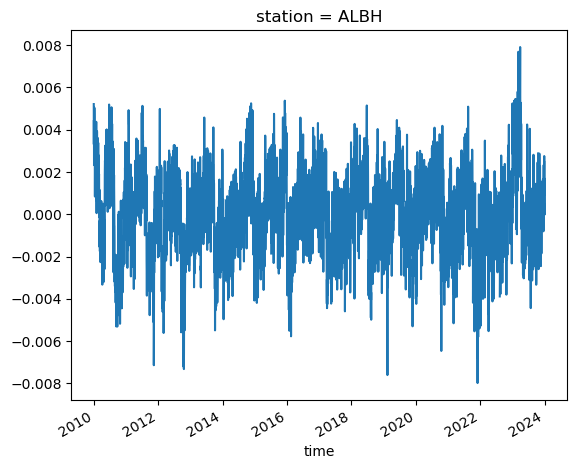

In [11]:
e_detrend.sel(station="ALBH").plot()

## Replace outliers and min max normalization

In [12]:
def replace_outliers(data, perc=0.99):
    # calculate percentile
    threshold = data.quantile(perc)
    print(f"threshold = {threshold.data}")
    # find outliers and replace them with nan
    return data.where(abs(data)<=threshold)

In [13]:
ds = ds.assign(variables={"n_clean": (dims, replace_outliers(ds.n_detrend).data)})
ds = ds.assign(variables={"e_clean": (dims, replace_outliers(ds.e_detrend).data)})
ds = ds.assign(variables={"z_clean": (dims, replace_outliers(ds.z_detrend).data)})

ds = ds.assign(variables={"n_norm": (dims, ((ds.n_clean.data-ds.n_clean.min().data)/(ds.n_clean.max().data-ds.n_clean.min().data))*2-1)})
ds = ds.assign(variables={"e_norm": (dims, ((ds.e_clean.data-ds.e_clean.min().data)/(ds.e_clean.max().data-ds.e_clean.min().data))*2-1)})
ds = ds.assign(variables={"z_norm": (dims, ((ds.z_clean.data-ds.z_clean.min().data)/(ds.z_clean.max().data-ds.z_clean.min().data))*2-1)})
ds

threshold = 0.00843594997288026
threshold = 0.008254049013949324
threshold = 0.026949977567187956


<xarray.Dataset>
Dimensions:    (time: 5114, station: 1101)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2024-01-01
  * station    (station) object '34A1' '34A2' '34A3' ... 'YONC' 'ZOLE' 'ZSE1'
Data variables: (12/15)
    e          (time, station) float64 nan nan nan nan ... -0.05722 nan 0.474
    n          (time, station) float64 ...
    z          (time, station) float64 ...
    latitude   (station) float64 ...
    longitude  (station) float64 ...
    height     (station) float64 ...
    ...         ...
    n_clean    (time, station) float64 nan nan nan ... 0.001289 nan 0.0005243
    e_clean    (time, station) float64 nan nan nan ... -0.0009017 nan -0.001911
    z_clean    (time, station) float64 nan nan nan ... -0.001431 nan 0.0005275
    n_norm     (time, station) float64 nan nan nan nan ... 0.1528 nan 0.06211
    e_norm     (time, station) float64 nan nan nan nan ... -0.1092 nan -0.2315
    z_norm     (time, station) float64 nan nan nan nan ... -0.05311 nan 0.01957

In [15]:
import joblib

scalers = {'n':[ds.n_clean.min().data, ds.n_clean.max().data], 
           'e':[ds.e_clean.min().data, ds.e_clean.max().data], 
           'z':[ds.z_clean.min().data, ds.z_clean.max().data]}


joblib.dump(scalers, "./scalers_daily_UNR")

['./scalers_daily_UNR']

## Verrification at one station

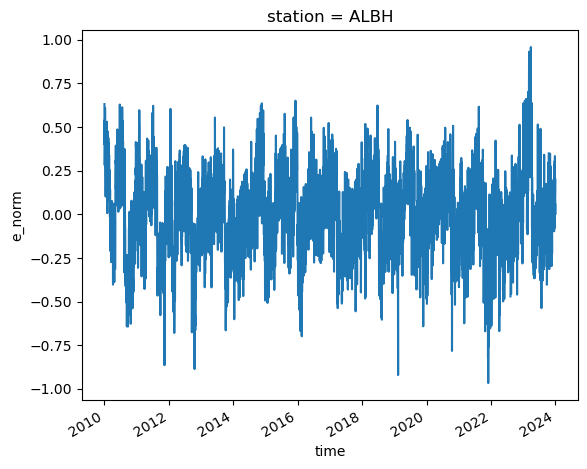

In [16]:
ds.sel(station='ALBH').e_norm.plot()

# save new ds

In [17]:
ds.to_netcdf("../data/clean_daily_UNR.nc")

In [18]:
ds_fit = xr.Dataset(
            data_vars=dict(
                n=(["station", "time"], trends_n.data),
                e=(["station", "time"], trends_e.data),
                z=(["station", "time"], trends_z.data),
                ),
            coords=dict(
                station=(["station"], trends_n.station.data),
                time=trends_n.time.data)
            )
ds_fit

<xarray.Dataset>
Dimensions:  (station: 1101, time: 5114)
Coordinates:
  * station  (station) <U4 '34A1' '34A2' '34A3' '34A4' ... 'YONC' 'ZOLE' 'ZSE1'
  * time     (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2024-01-01
Data variables:
    n        (station, time) float64 0.35 0.35 0.35 ... 0.01073 0.01071 0.01068
    e        (station, time) float64 0.3778 0.3778 0.3778 ... 0.476 0.476 0.4759
    z        (station, time) float64 0.7091 0.7091 0.709 ... 0.6327 0.6327

In [19]:
ds_fit.to_netcdf("./fit_daily_UNR.nc")